In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

sns.set(style="whitegrid")

import os
import sys
from pathlib import Path
from zipfile import ZipFile

PROJ_ROOT = Path(os.getcwd()).parent.parent
sys.path.append(str(PROJ_ROOT))  # add project root file to the python paths

In [5]:
data_path = PROJ_ROOT / "data"
raw_data_path = data_path / "raw"

# Loop through files and compute OB features   

The logic of calculations in this notebook are the same as the ones in the `1.0-mz-eda.ipynb` notebook. The only difference is that this notebook loops through all the files in the `data/` directory and computes the OB features for each file. The results are saved in a new directory called `data/output`.

In [23]:
csv_files = list(raw_data_path.glob("bitstamp_ob*.zip"))
csv_files[:5]

[PosixPath('/home/miroslav/Documents/projects/mlfcs/data/raw/bitstamp_ob_25_06_2018.zip'),
 PosixPath('/home/miroslav/Documents/projects/mlfcs/data/raw/bitstamp_ob_22_06_2018.zip'),
 PosixPath('/home/miroslav/Documents/projects/mlfcs/data/raw/bitstamp_ob_18_06_2018.zip'),
 PosixPath('/home/miroslav/Documents/projects/mlfcs/data/raw/bitstamp_ob_05_09_2018.zip'),
 PosixPath('/home/miroslav/Documents/projects/mlfcs/data/raw/bitstamp_ob_05_06_2018.zip')]

In [24]:
dataframes = []

for csv_file in tqdm(csv_files, desc="Processing CSV files"):
    # load and format
    ob_sample = (
        pl.read_csv(
            ZipFile(raw_data_path / csv_file.name).read(csv_file.name[:-4] + ".csv")
        )
        .with_columns((pl.col("type") == "b").alias("is_bid"))
        .drop("type")
        .rename({"amount ": "amount"})
    )

    # calculate volume, depth, spread, volume_diff, and depth_diff
    time_agg = (
        ob_sample.group_by(["time"])
        .agg(
            pl.when(pl.col("is_bid"))
            .then(pl.col("amount"))
            .otherwise(None)
            .sum()
            .alias("bid_volume"),
            pl.when(~pl.col("is_bid"))
            .then(pl.col("amount"))
            .otherwise(None)
            .sum()
            .alias("ask_volume"),
            pl.when(pl.col("is_bid"))
            .then(pl.col("price"))
            .otherwise(None)
            .max()
            .alias("max_bid"),
            pl.when(~pl.col("is_bid"))
            .then(pl.col("price"))
            .otherwise(None)
            .min()
            .alias("min_ask"),
            pl.when(pl.col("is_bid") & (pl.col("price") > 1000.0))  ### FILTER !!!
            .then(pl.col("price"))
            .otherwise(None)
            .count()
            .alias("bid_depth"),
            pl.when(~pl.col("is_bid"))
            .then(pl.col("price"))
            .otherwise(None)
            .count()
            .alias("ask_depth"),
        )
        .cast({"bid_depth": pl.Int32, "ask_depth": pl.Int32})
        .sort("time")
    ).with_columns(
        (pl.col("ask_depth") - pl.col("bid_depth")).alias("depth_diff"),
        (pl.col("min_ask") - pl.col("max_bid")).alias("spread"),
        (pl.col("bid_volume") - pl.col("ask_volume")).alias("volume_diff"),
    )

    # aggregate data from the original dataframe over the 10th "percentiles"
    time_quantile_agg = ob_sample.group_by(["time"]).agg(
        pl.when(pl.col("is_bid"))
        .then(pl.col("price"))
        .otherwise(None)
        .quantile(0.9)
        .alias("bid_delta"),
        pl.when(~pl.col("is_bid"))
        .then(pl.col("price"))
        .otherwise(None)
        .quantile(0.1)
        .alias("ask_delta"),
    )

    time_agg_weighted = (
        pl.concat([ob_sample, time_quantile_agg], how="align_right")
        .group_by(["time"])
        .agg(
            # filter only bid prices over the 10th percentile of bid prices
            pl.when(pl.col("is_bid") & (pl.col("price") >= pl.col("bid_delta")))
            .then(pl.col("amount"))
            .otherwise(0.0)
            .sum()
            .alias("bid_slope"),
            # filter only ask prices under the 90th percentile of ask prices
            pl.when(~pl.col("is_bid") & (pl.col("price") <= pl.col("ask_delta")))
            .then(pl.col("amount"))
            .otherwise(0.0)
            .sum()
            .alias("ask_slope"),
            pl.when(pl.col("is_bid") & (pl.col("price") >= pl.col("bid_delta")))
            .then(pl.col("price"))
            .otherwise(None)
            .min()
            .alias("weighted_bid"),
            pl.when(~pl.col("is_bid") & (pl.col("price") <= pl.col("ask_delta")))
            .then(pl.col("price"))
            .otherwise(None)
            .max()
            .alias("weighted_ask"),
        )
        .with_columns(
            (pl.col("weighted_ask") - pl.col("weighted_bid")).alias("weighted_spread"),
        )
    )

    dataframes.append(
        pl.concat([time_agg, time_agg_weighted], how="align").sort("time")
    )

Processing CSV files: 100%|██████████| 109/109 [18:03<00:00,  9.94s/it]


In [25]:
features = (
    pl.concat(dataframes, how="vertical")
    .with_columns(pl.from_epoch("time"))
    .sort("time")
)

In [26]:
features

time,bid_volume,ask_volume,max_bid,min_ask,bid_depth,ask_depth,depth_diff,spread,volume_diff,bid_slope,ask_slope,weighted_bid,weighted_ask,weighted_spread
datetime[μs],f64,f64,f64,f64,i32,i32,i32,f64,f64,f64,f64,f64,f64,f64
2018-06-04 22:00:02,586356.113693,2695.804973,7537.0,7543.19,3047,5000,1953,6.19,583660.30872,934.466054,868.789883,7100.29,8210.0,1109.71
2018-06-04 22:00:34,586351.269401,2696.561478,7537.0,7543.19,3047,5000,1953,6.19,583654.707923,929.621762,869.597349,7100.29,8204.47,1104.18
2018-06-04 22:01:01,586350.938081,2699.165417,7537.0,7541.97,3047,5000,1953,4.97,583651.772664,929.290442,872.151288,7100.29,8203.44,1103.15
2018-06-04 22:01:33,586307.355517,2656.934508,7537.01,7541.97,3045,5000,1955,4.96,583650.421009,894.15346,829.919417,7099.0,8210.0,1111.0
2018-06-04 22:02:02,586317.596946,2657.946212,7537.0,7541.9,3046,5000,1954,4.9,583659.650734,903.394889,830.982083,7100.0,8204.47,1104.47
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2018-09-30 21:57:34,502228.305974,2954.913408,6554.21,6555.79,3105,5000,1895,1.58,499273.392566,712.889159,1205.409876,6219.69,7117.0,897.31
2018-09-30 21:58:01,502208.483731,2926.069752,6554.19,6555.78,3101,5000,1899,1.59,499282.413979,693.241974,1176.826778,6215.45,7124.47,909.02
2018-09-30 21:58:34,502203.145173,2927.899054,6555.0,6555.76,3102,5000,1898,0.76,499275.246118,687.801047,1178.65608,6215.5,7124.47,908.97


In [ ]:
# save the features to a parquet file
features.write_parquet(data_path / "output" / "ob_features.parquet")

In [4]:
# lead features
features = pl.read_parquet(data_path / "output" / "ob_features.parquet")

# Inspect the aggregated OB features and compare with Vi's preprocessing

## Plot before any filtering

In [52]:
# plot features one by one
def plot_feature(df, feature, problematic_timestamps=None):
    plt.figure(figsize=(12, 3))
    plt.scatter(df["time"], df[feature], label=feature, alpha=1, s=0.3)
    plt.title(f"{feature} over time")
    plt.xlabel("Time")
    plt.ylabel(feature)
    plt.legend()

    if problematic_timestamps is not None:
        for timestamp in problematic_timestamps:
            plt.axvline(
                x=timestamp, color="r", linestyle="--", label="Problematic Timestamp"
            )
    plt.show()

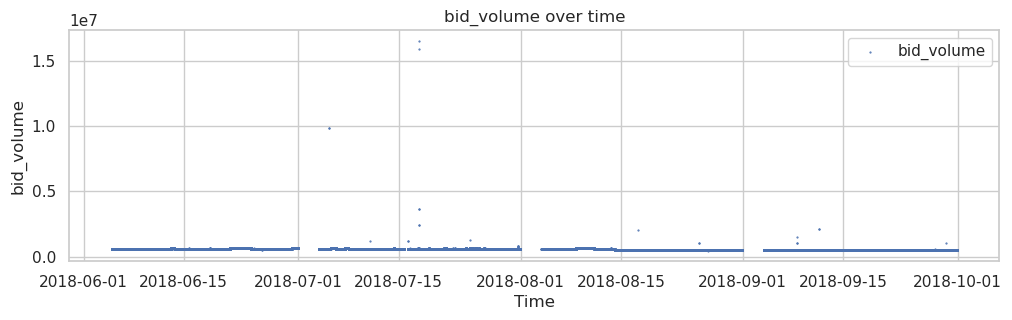

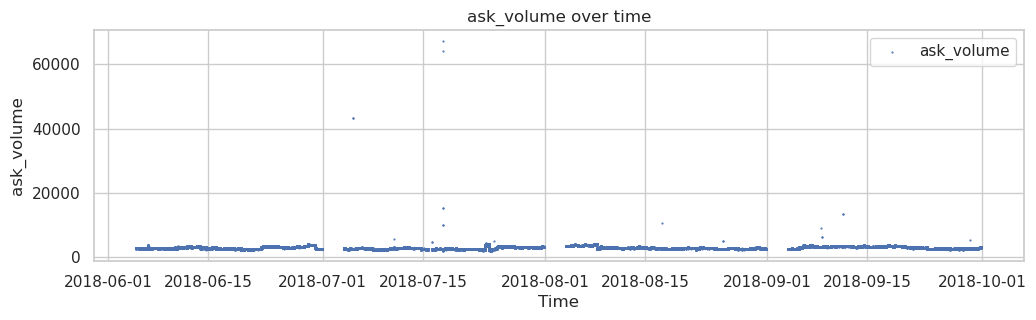

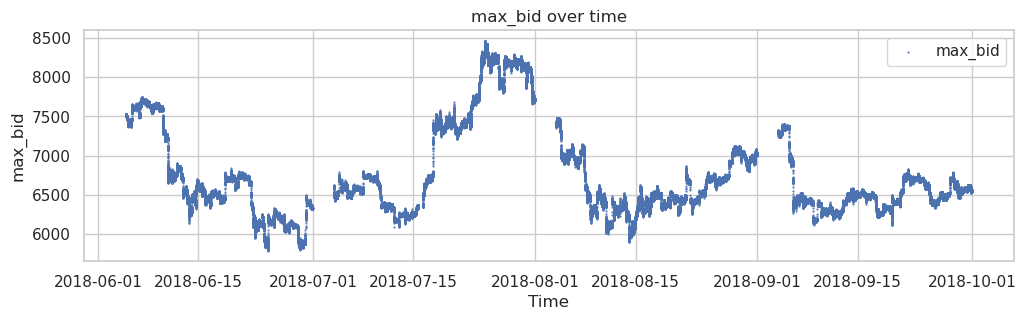

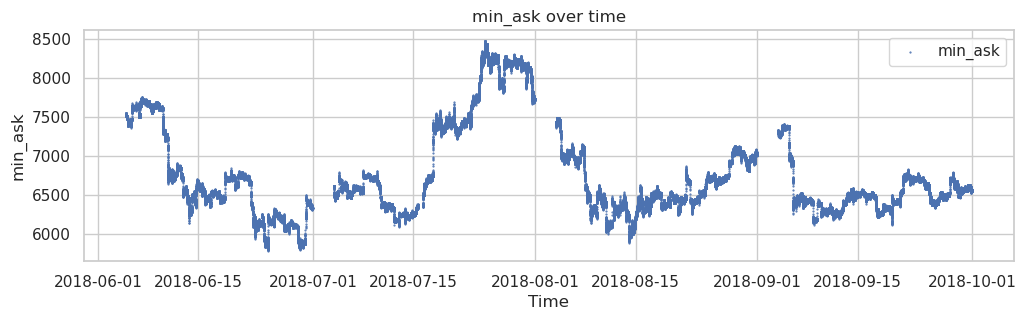

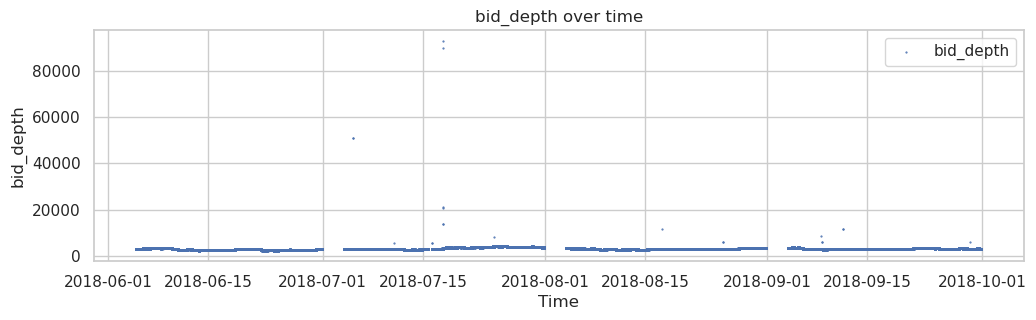

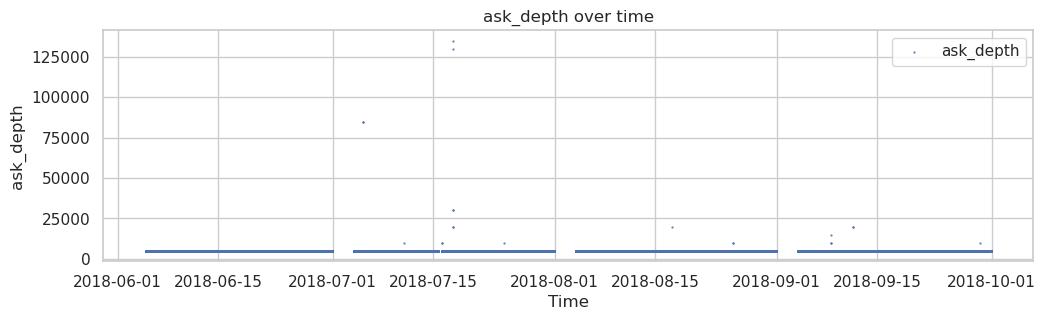

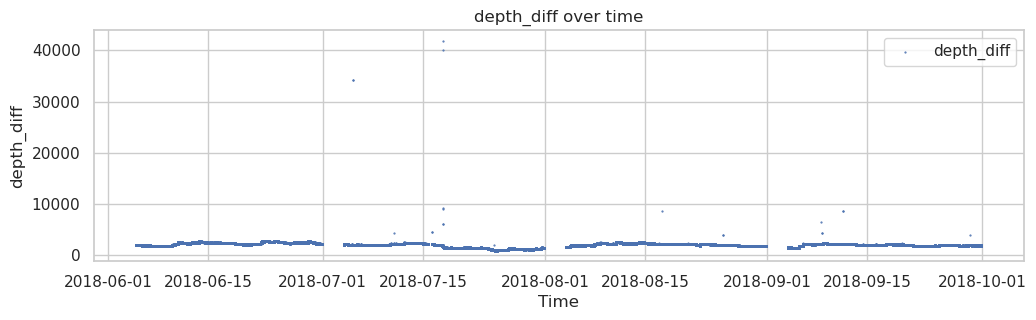

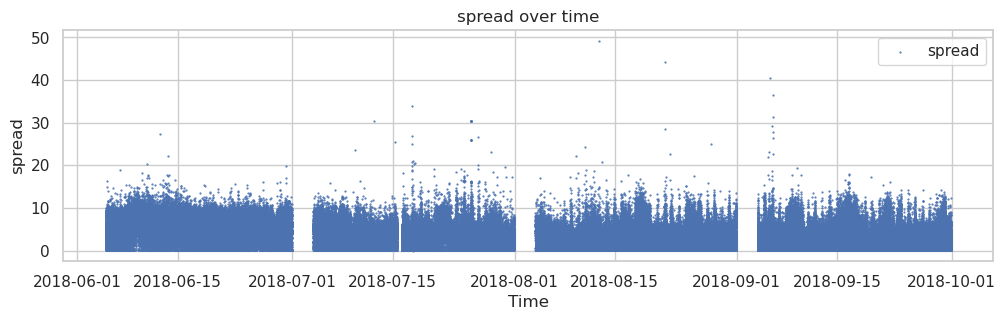

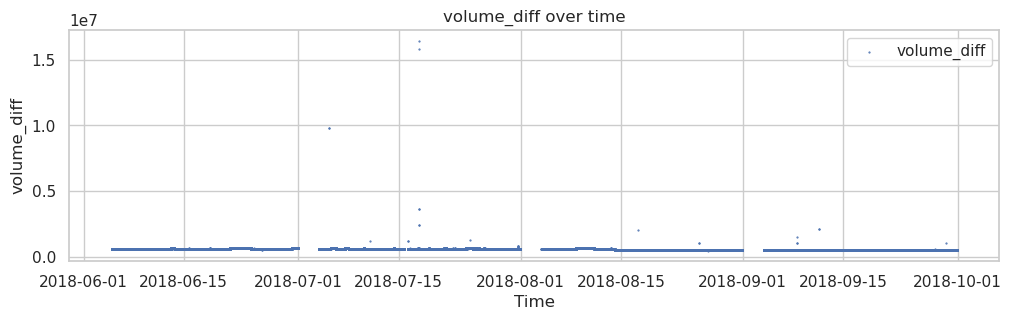

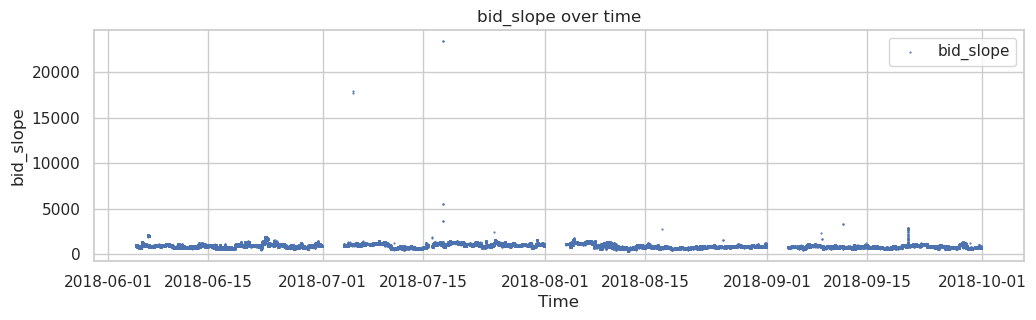

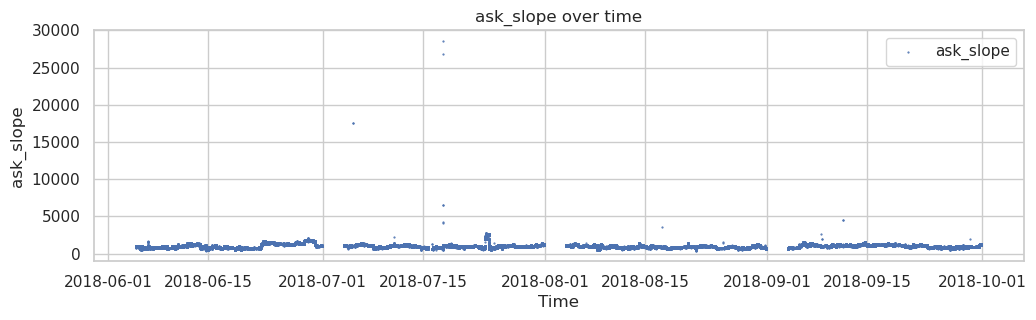

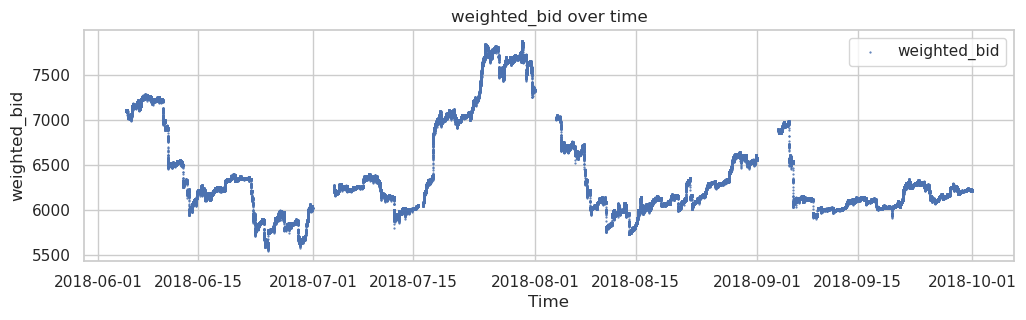

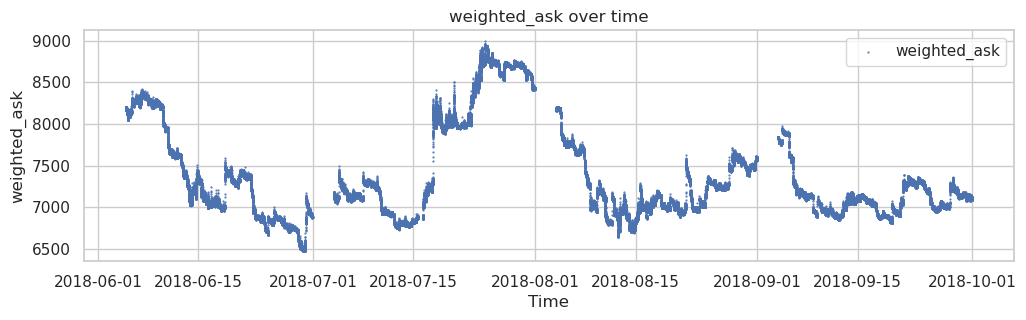

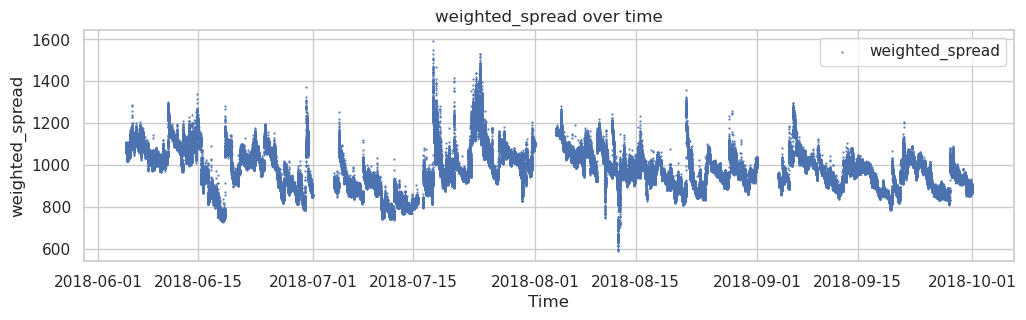

In [7]:
for feature in features.columns:
    if feature not in ["time", "bid_delta", "ask_delta"]:
        plot_feature(features, feature)

Observations:
- There are missing data for the first four days in each month, giving 3 windows of missing data.
- There are outliers in `bid_slope`, `ask_slope`, `bid_volume`, `ask_volume`, `volume_diff`, `bid_depth` and `ask_depth`, `depth_diff` features. 

## Check if Vi's features have outliers 

Let's check if the same outliers are present in Viacheslav's features (although this may not the up to date version of his features).

In [85]:
vis_features = (
    pl.read_csv(data_path / "btc" / "features.csv")
    .with_columns(pl.col("time").str.to_datetime("%Y-%m-%d %H:%M:%S"))
    .sort("time")
)
vis_features

time,spread,ask_depth,bid_depth,depth_diff,ask_volume,bid_volume,volume_diff,weighted_spread,ask_slope,bid_slope
datetime[μs],f64,i64,i64,i64,f64,f64,f64,f64,f64,f64
2018-06-04 22:00:02,6.19,4000,2808,1192,2288.215849,12731.737072,-10443.521223,1051.57871,7581.61,6964.01
2018-06-04 22:00:34,6.19,4000,2808,1192,2288.534415,12726.89278,-10438.358364,1045.915353,7581.61,6964.01
2018-06-04 22:01:01,4.97,4000,2808,1192,2291.262389,12726.56146,-10435.299071,1047.082641,7581.03,6964.01
2018-06-04 22:01:33,4.96,4000,2806,1194,2249.345384,12682.978896,-10433.633512,1045.631341,7587.31,6929.32
2018-06-04 22:02:02,4.9,4000,2807,1193,2249.91915,12693.220325,-10443.301176,1041.502402,7587.07,6945.0
…,…,…,…,…,…,…,…,…,…,…
2018-09-30 21:57:34,1.58,4000,2836,1164,2577.148039,11880.676125,-9303.528086,962.447407,6618.0,6060.0
2018-09-30 21:58:01,1.59,4000,2833,1167,2548.567998,11861.303882,-9312.735884,954.261985,6618.0,6060.0
2018-09-30 21:58:34,0.76,4000,2834,1166,2550.3973,11855.965324,-9305.568024,947.094124,6618.0,6060.0


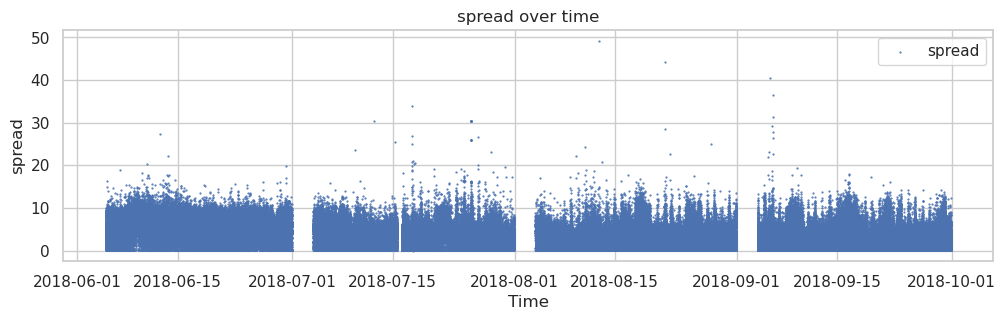

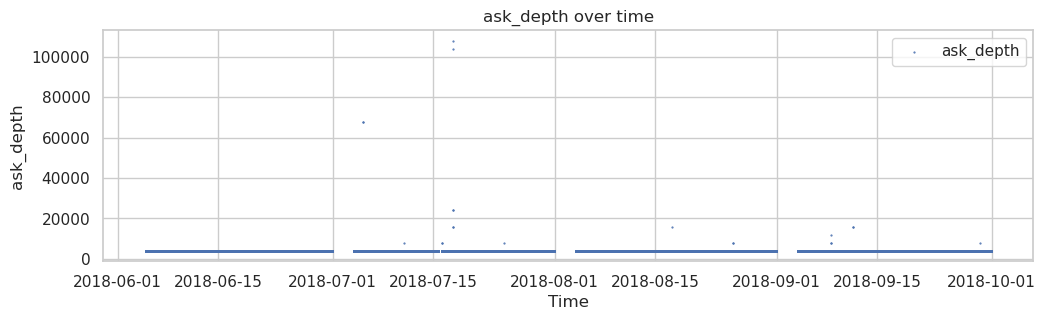

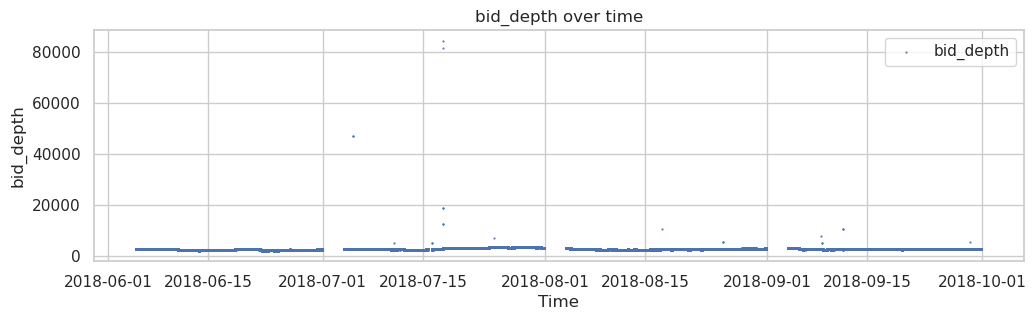

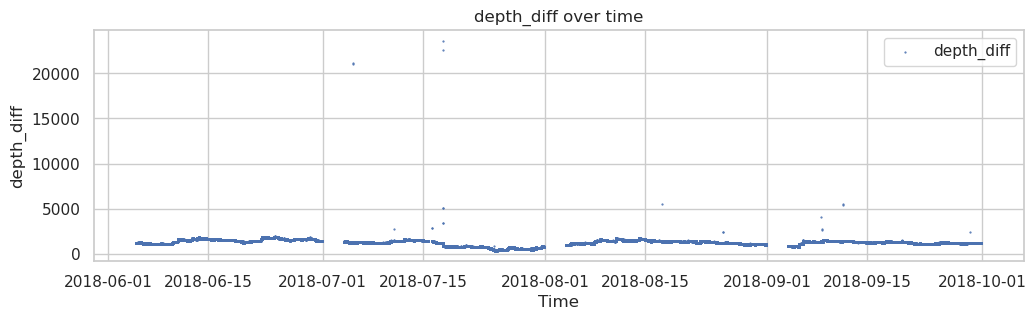

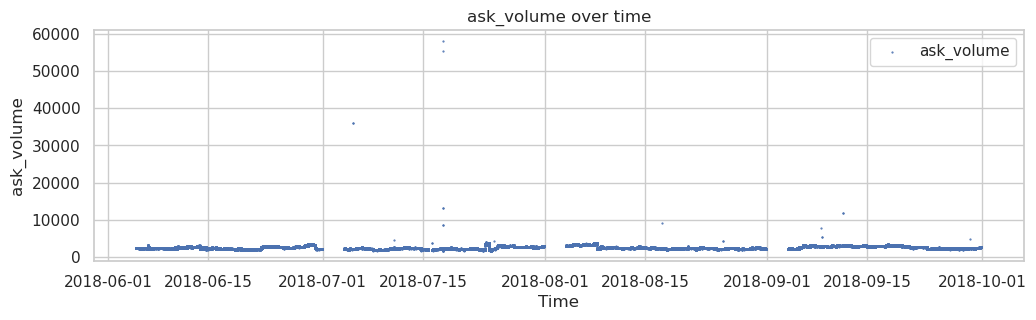

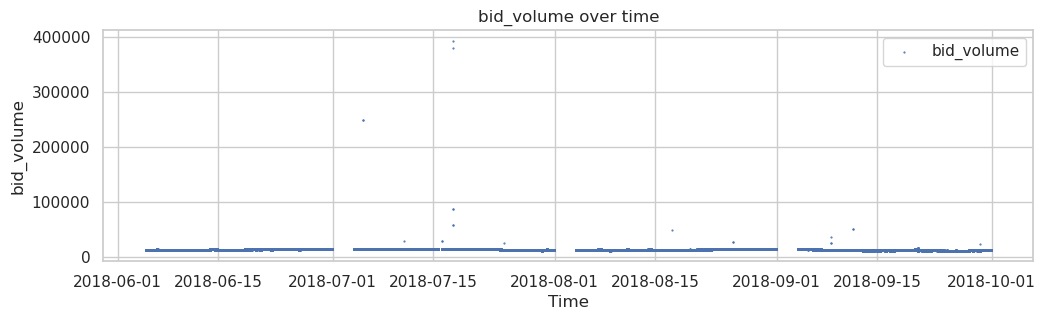

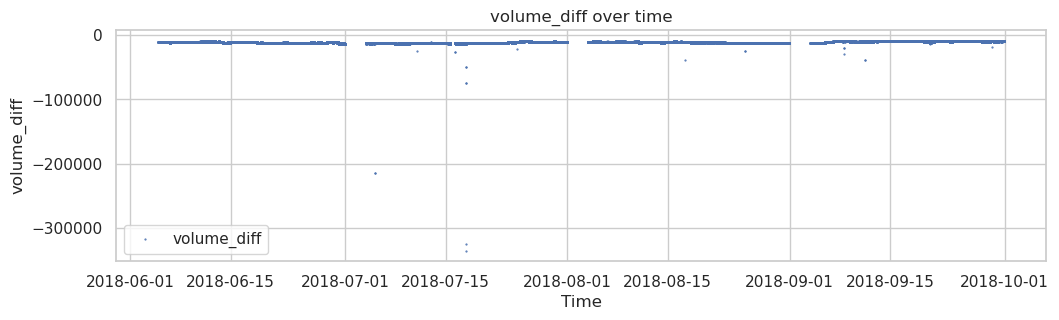

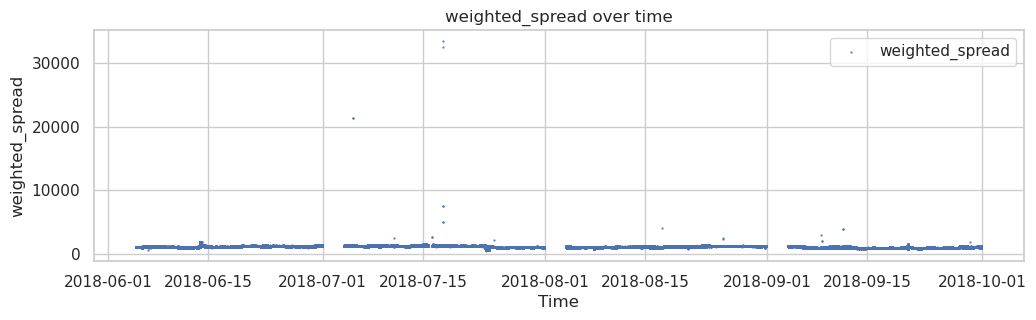

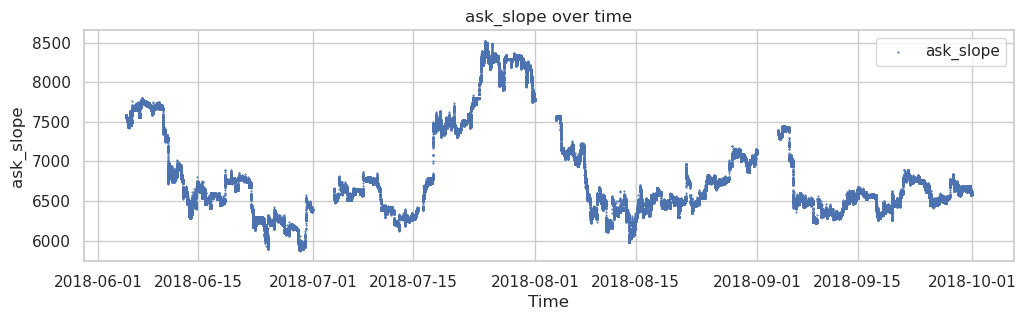

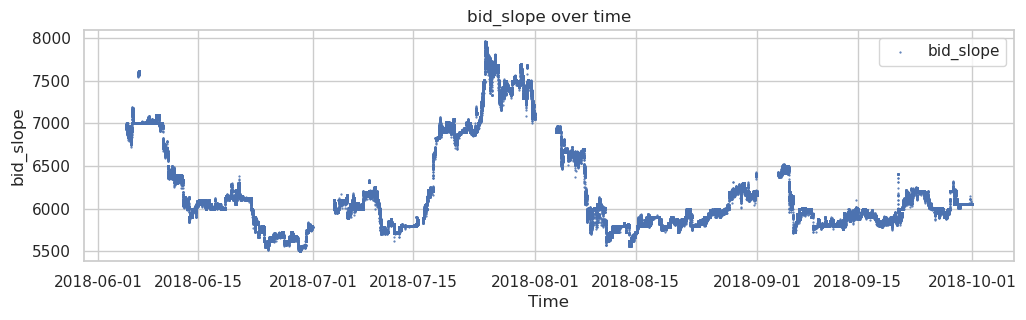

In [86]:
for feature in vis_features.columns:
    if feature not in ["time"]:
        plot_feature(vis_features, feature)

Seems like Viecheslav's features also have outliers adn the same missing data. `features.csv` is probably the old file. Look forward in this notebook, `data_df.csv` does not have these outliers.

## Filter outliers

From the above plots, it seems that the outliers are all related to the same few timestamps. We will sort the data by bid_depth or ask_depth, as these two features seem to be mostly constant over time, and the we will remove the rows with the few highest values by manually setting the threshold.

In [119]:
problematic_timestamps = []

In [120]:
problematic_timestamps.extend(
    features.filter(pl.col("bid_depth") > 5000).select("time").to_series().to_list()
)
features.sort("bid_depth", descending=True).filter(pl.col("bid_depth") > 5000).shape

(21, 15)

In [121]:
problematic_timestamps.extend(
    features.filter(pl.col("ask_depth") > 5000).select("time").to_series().to_list()
)
features.sort("ask_depth", descending=True).filter(pl.col("ask_depth") > 5000).shape

(21, 15)

In [122]:
problematic_timestamps.extend(
    features.filter(pl.col("bid_volume") > 900_000).select("time").to_series().to_list()
)
features.sort("bid_volume", descending=True).filter(
    pl.col("bid_volume") > 900_000
).shape

(21, 15)

In [123]:
problematic_timestamps.extend(
    features.filter(pl.col("ask_volume") > 8000).select("time").to_series().to_list()
)
features.sort("ask_volume", descending=True).filter(pl.col("ask_volume") > 8000).shape

(12, 15)

In [124]:
problematic_timestamps.extend(
    features.filter(pl.col("bid_slope") > 4000).select("time").to_series().to_list()
)
features.sort("bid_slope", descending=True).filter(pl.col("bid_slope") > 4000).shape

(6, 15)

In [125]:
problematic_timestamps.extend(
    features.filter(pl.col("ask_slope") > 4000).select("time").to_series().to_list()
)
features.sort("ask_slope", descending=True).filter(pl.col("ask_slope") > 4000).shape

(10, 15)

In [126]:
# union of the problematic timestamps
problematic_timestamps = list(set(problematic_timestamps))

In [127]:
len(problematic_timestamps)

21

In [128]:
# filer out the problematic timestamps
features = features.filter(~pl.col("time").is_in(problematic_timestamps))

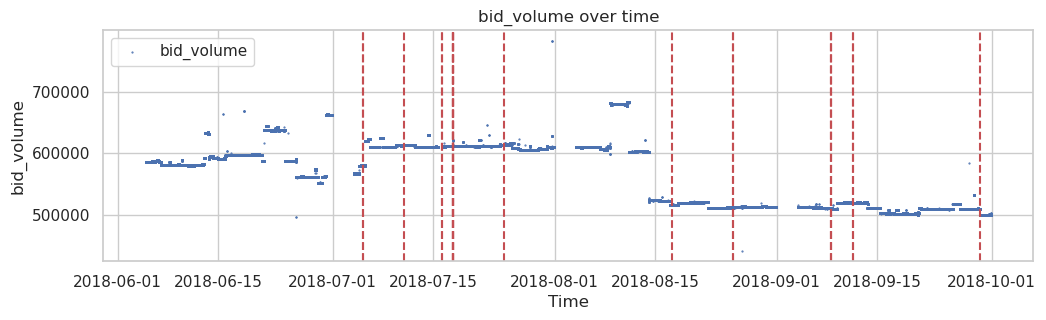

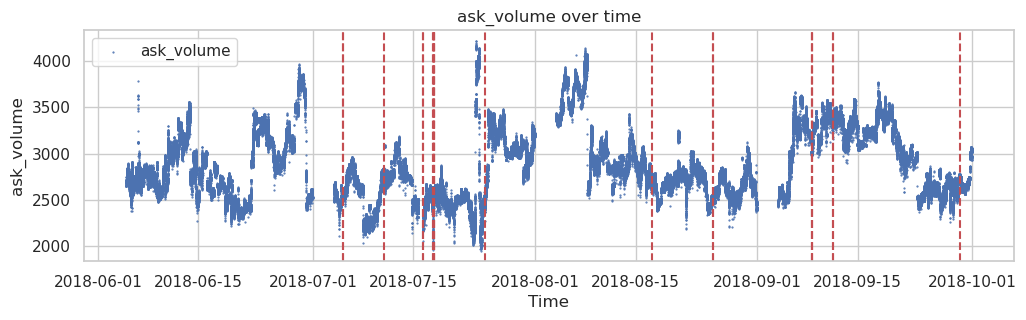

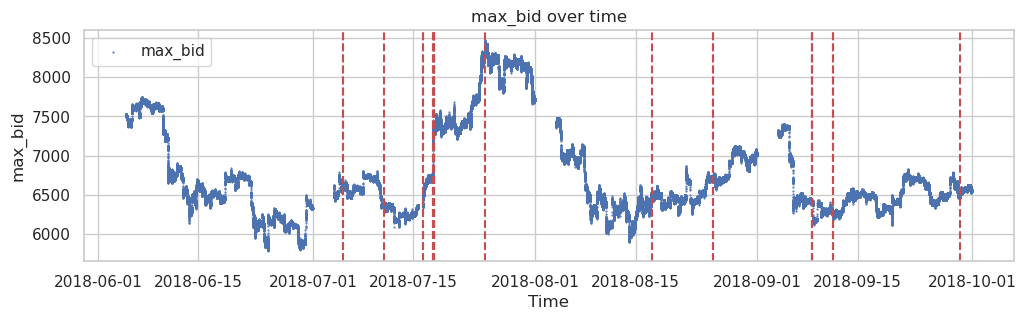

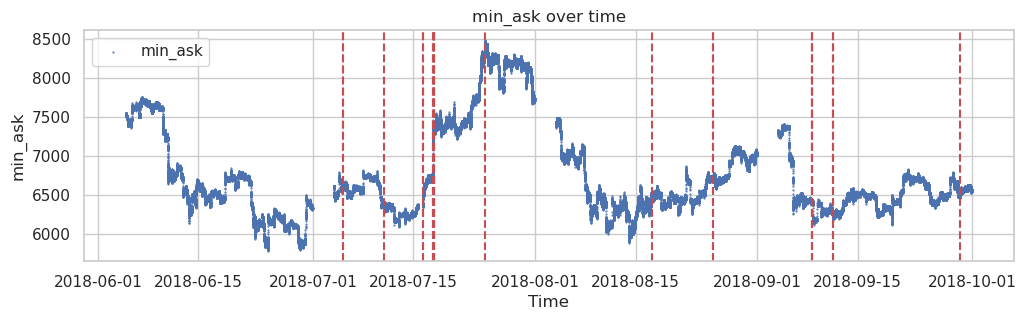

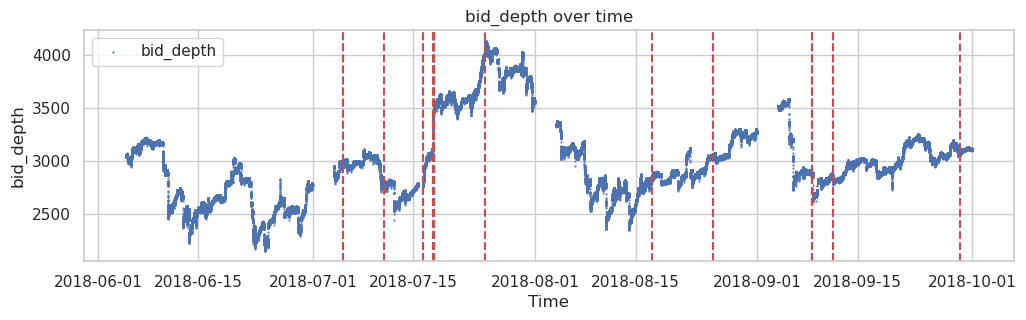

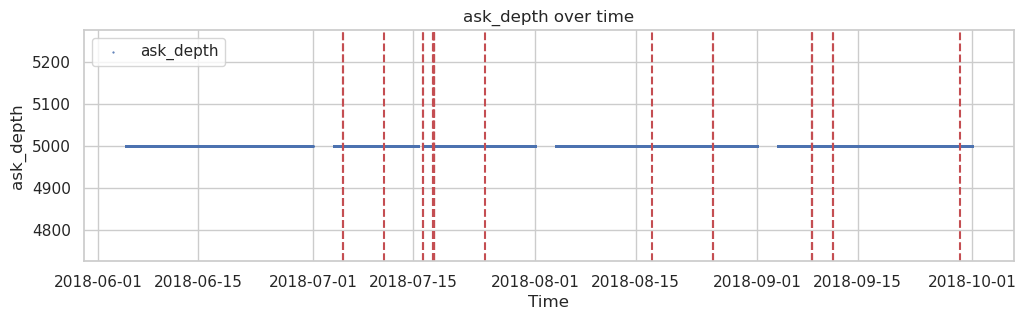

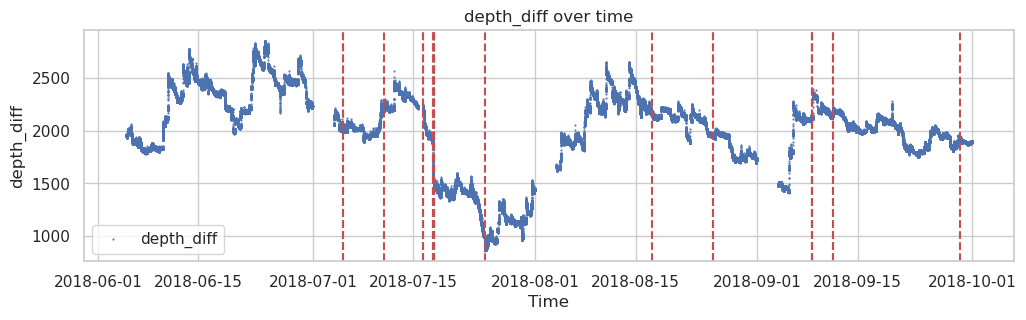

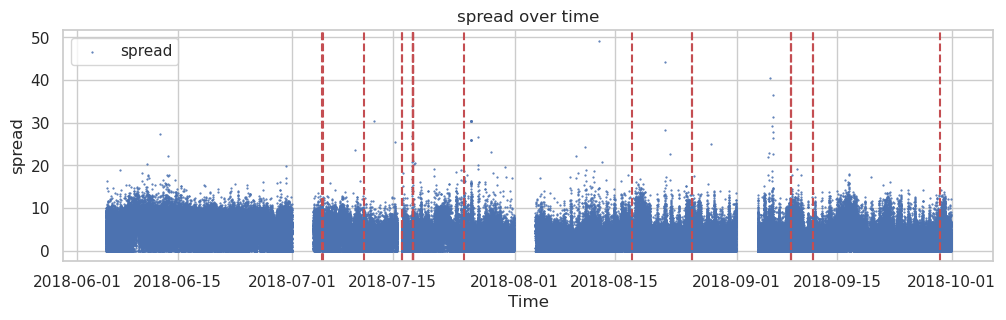

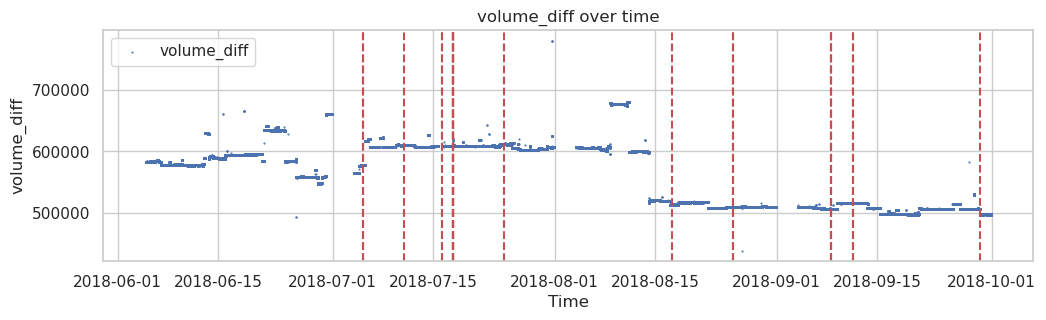

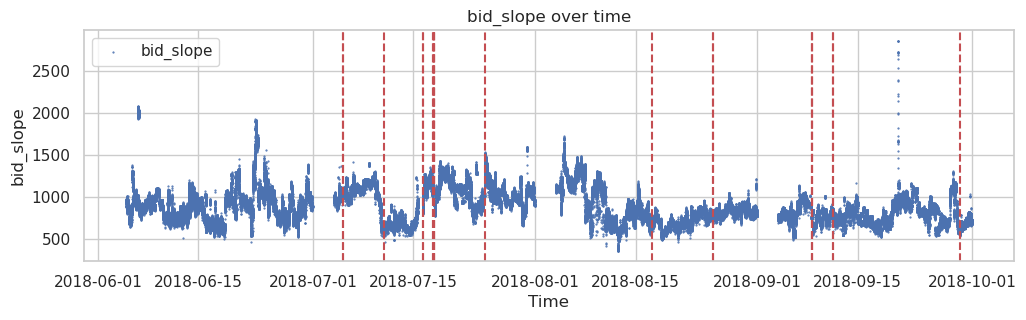

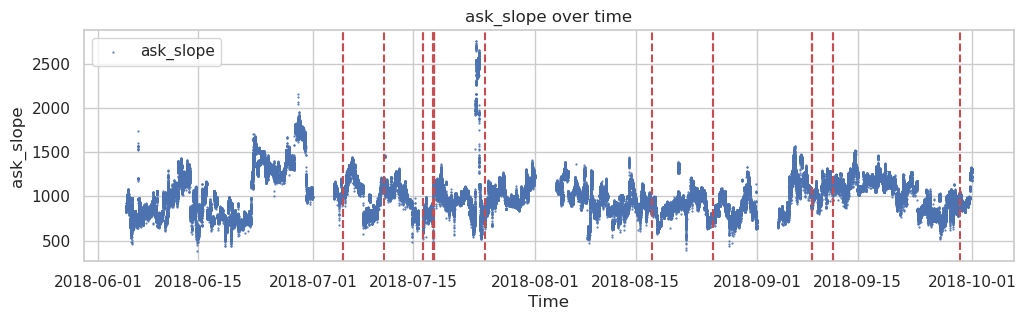

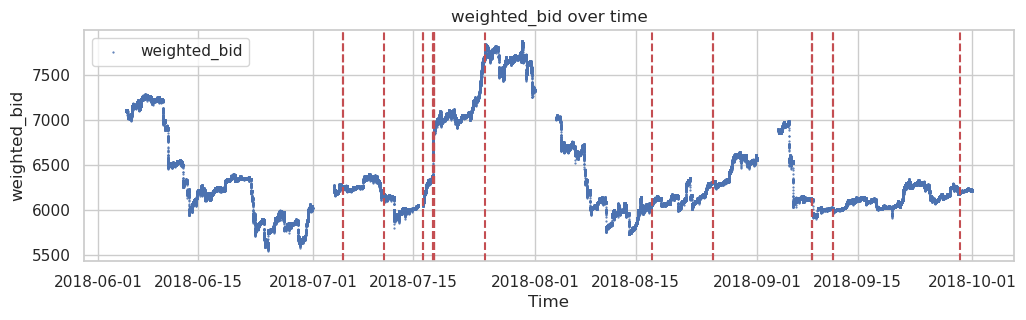

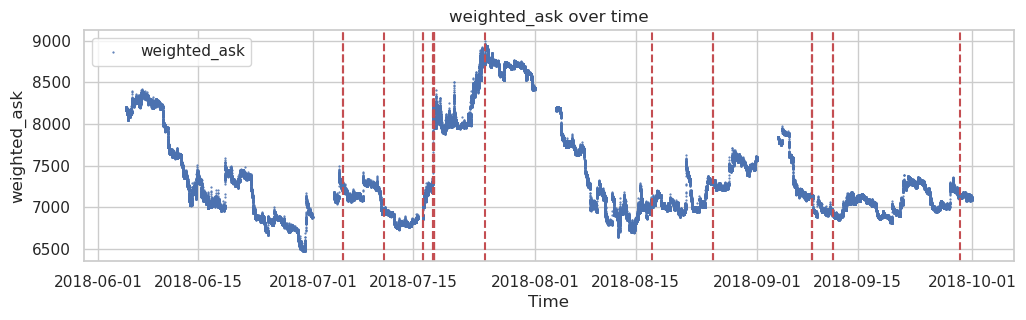

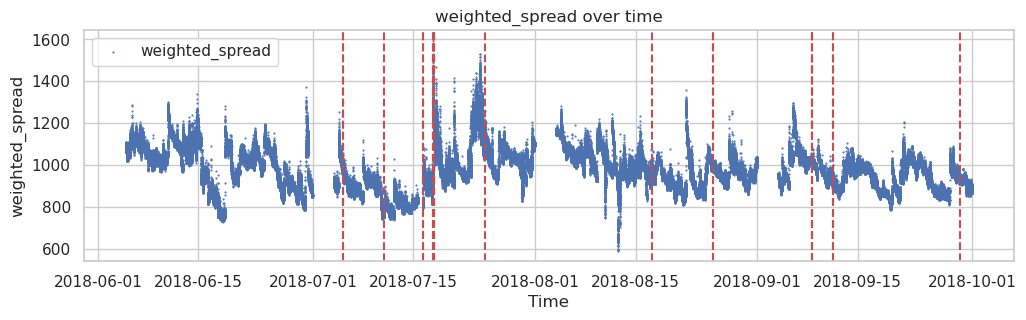

In [129]:
# plot the features again
for feature in features.columns:
    if feature not in ["time", "bid_delta", "ask_delta"]:
        plot_feature(features, feature, problematic_timestamps)

## Compare with Vi's data

Let's check if the same problem appears in the dataset preprocessed by Viecheslav's code.

In [13]:
vis_data = (
    pl.read_csv(data_path / "btc" / "data_df.csv")
    .with_columns(pl.col("datetime").str.to_datetime("%Y-%m-%d %H:%M:%S"))
    .sort("datetime")
)
vis_data

datetime,vol,ret,ret_t-1,ret_t-2,ret_t-3,ret_t-4,ret_t-5,ret_t-6,ret_t-7,ret_t-8,ret_t-9,ret_t-10,ret_t-11,ret_t-12,spread_t-1,ask_depth_t-1,bid_depth_t-1,depth_diff_t-1,ask_volume_t-1,bid_volume_t-1,volume_diff_t-1,weighted_spread_t-1,ask_slope_t-1,bid_slope_t-1,spread_t-2,ask_depth_t-2,bid_depth_t-2,depth_diff_t-2,ask_volume_t-2,bid_volume_t-2,volume_diff_t-2,weighted_spread_t-2,ask_slope_t-2,bid_slope_t-2,spread_t-3,ask_depth_t-3,…,depth_diff_t-117,ask_volume_t-117,bid_volume_t-117,volume_diff_t-117,weighted_spread_t-117,ask_slope_t-117,bid_slope_t-117,spread_t-118,ask_depth_t-118,bid_depth_t-118,depth_diff_t-118,ask_volume_t-118,bid_volume_t-118,volume_diff_t-118,weighted_spread_t-118,ask_slope_t-118,bid_slope_t-118,spread_t-119,ask_depth_t-119,bid_depth_t-119,depth_diff_t-119,ask_volume_t-119,bid_volume_t-119,volume_diff_t-119,weighted_spread_t-119,ask_slope_t-119,bid_slope_t-119,spread_t-120,ask_depth_t-120,bid_depth_t-120,depth_diff_t-120,ask_volume_t-120,bid_volume_t-120,volume_diff_t-120,weighted_spread_t-120,ask_slope_t-120,bid_slope_t-120
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2018-06-04 23:00:00,0.000143,-0.002229,-0.000807,-0.001664,-0.002068,0.001077,-0.00226,0.000301,0.00099,0.000041,0.000301,-0.000043,-0.000157,-0.000768,6.19,4000.0,2808.0,1192.0,2288.215849,12731.737072,-10443.521223,1051.57871,7581.61,6964.01,6.19,4000.0,2808.0,1192.0,2288.534415,12726.89278,-10438.358364,1045.915353,7581.61,6964.01,4.97,4000.0,…,1188.0,2340.278935,12783.21809,-10442.939155,1039.347393,7548.68,6997.83,4.23,4000.0,2812.0,1188.0,2343.197335,12785.218086,-10442.02075,1040.06992,7548.68,6998.87,4.21,4000.0,2810.0,1190.0,2343.828396,12779.487992,-10435.659596,1038.694529,7548.68,6988.0,4.38,4000.0,2809.0,1191.0,2341.940396,12782.456607,-10440.51621,1036.725648,7548.68,6997.83
2018-06-05 00:00:00,0.000115,0.001552,-0.000217,-0.002412,-0.000731,-0.000816,0.000611,0.000842,-0.000742,0.001837,0.000032,0.000767,0.000156,-0.001553,4.98,4000.0,2809.0,1191.0,2340.268453,12783.096196,-10442.827743,1041.567985,7548.68,6997.83,2.86,4000.0,2811.0,1189.0,2342.126435,12779.53409,-10437.407654,1035.132687,7548.68,6988.01,4.07,4000.0,…,1194.0,2338.071193,12707.422222,-10369.351029,1042.644788,7543.27,6946.64,6.98,4000.0,2803.0,1197.0,2342.916282,12708.86313,-10365.946848,1038.317067,7542.04,6946.64,6.98,4000.0,2804.0,1196.0,2366.325356,12717.023462,-10350.698106,1042.515684,7542.04,6946.64,6.75,4000.0,2802.0,1198.0,2362.768003,12699.117466,-10336.349463,1031.800062,7539.55,6937.0
2018-06-05 01:00:00,0.00009,-0.001719,0.001004,0.00056,0.000503,-0.000766,-0.000041,-0.000289,-0.000918,0.00012,0.000027,0.001234,-0.000299,0.000419,6.52,4000.0,2804.0,1196.0,2347.396383,12693.048433,-10345.65205,1032.538554,7543.39,6942.12,1.86,4000.0,2796.0,1204.0,2303.342549,12638.617613,-10335.275064,1022.538023,7546.93,6894.8,1.35,4000.0,…,1183.0,2351.561233,12788.640038,-10437.078805,1051.113045,7531.36,6981.42,8.62,4000.0,2815.0,1185.0,2359.18592,12788.840714,-10429.654794,1043.127834,7531.36,6981.42,8.53,4000.0,2817.0,1183.0,2353.856788,12788.49671,-10434.639922,1034.674162,7531.37,6981.42,7.99,4000.0,2817.0,1183.0,2349.182465,12790.666762,-10441.484297,1055.538487,7531.36,6981.42
2018-06-05 02:00:00,0.000502,-0.010899,0.000669,0.000013,-0.000724,0.000081,-0.001212,0.001144,-0.000175,-0.000356,-0.001544,-0.000848,0.001812,-0.000577,8.22,4000.0,2818.0,1182.0,2349.61451,12789.69343,-10440.078919,1054.133109,7531.36,6981.42,8.43,4000.0,2817.0,1183.0,2353.088547,12790.602604,-10437.514057,1036.308469,7531.37,6981.42,4.34,4000.0,…,1186.0,2364.910089,12747.40203,-10382.491941,1032.66053,7520.68,6970.0,5.81,4000.0,2810.0,1190.0,2364.712157,12741.994351,-10377.282194,1030.046079,7520.68,6970.0,3.82,4000.0,28

In [131]:
# select columns containing 't-1' suffix in the name
keep_cols = [col for col in vis_data.columns if col.endswith("t-1")]
keep_cols.extend(["datetime", "vol"])
keep_cols

['ret_t-1',
 'spread_t-1',
 'ask_depth_t-1',
 'bid_depth_t-1',
 'depth_diff_t-1',
 'ask_volume_t-1',
 'bid_volume_t-1',
 'volume_diff_t-1',
 'weighted_spread_t-1',
 'ask_slope_t-1',
 'bid_slope_t-1',
 'datetime',
 'vol']

In [132]:
# keep only the selected columns and shift the time column by 1
vis_data = vis_data.select(keep_cols)
vis_data

ret_t-1,spread_t-1,ask_depth_t-1,bid_depth_t-1,depth_diff_t-1,ask_volume_t-1,bid_volume_t-1,volume_diff_t-1,weighted_spread_t-1,ask_slope_t-1,bid_slope_t-1,datetime,vol
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,datetime[μs],f64
-0.000807,6.19,4000.0,2808.0,1192.0,2288.215849,12731.737072,-10443.521223,1051.57871,7581.61,6964.01,2018-06-04 23:00:00,0.000143
-0.000217,4.98,4000.0,2809.0,1191.0,2340.268453,12783.096196,-10442.827743,1041.567985,7548.68,6997.83,2018-06-05 00:00:00,0.000115
0.001004,6.52,4000.0,2804.0,1196.0,2347.396383,12693.048433,-10345.65205,1032.538554,7543.39,6942.12,2018-06-05 01:00:00,0.00009
0.000669,8.22,4000.0,2818.0,1182.0,2349.61451,12789.69343,-10440.078919,1054.133109,7531.36,6981.42,2018-06-05 02:00:00,0.000502
0.000473,4.81,4000.0,2812.0,1188.0,2356.662932,12729.654832,-10372.9919,1034.239725,7520.68,6964.01,2018-06-05 03:00:00,0.000146
…,…,…,…,…,…,…,…,…,…,…,…,…
-0.00086,2.51,4000.0,2837.0,1163.0,2634.212985,11905.43365,-9271.220665,990.015651,6618.0,6060.0,2018-09-30 17:00:00,0.000025
0.000607,0.08,4000.0,2841.0,1159.0,2627.386158,11908.671066,-9281.284908,1050.033244,6629.0,6060.0,2018-09-30 18:00:00,0.000014
-0.000023,3.11,4000.0,2844.0,1156.0,2614.121173,11901.490484,-9287.369312,971.968267,6631.0,6060.0,2018-09-30 19:00:00,0.000024


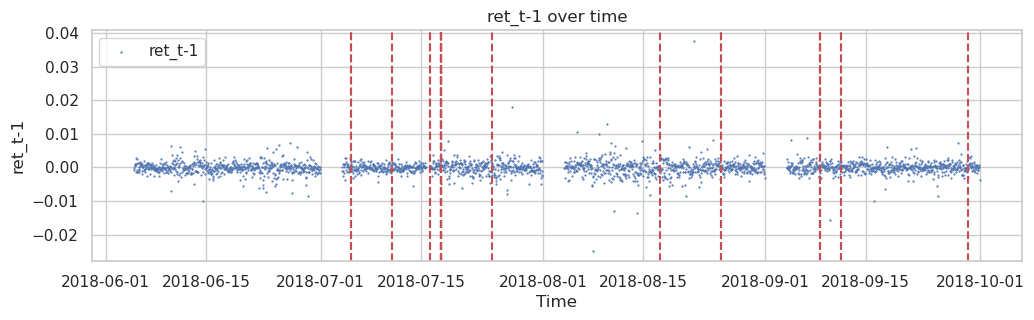

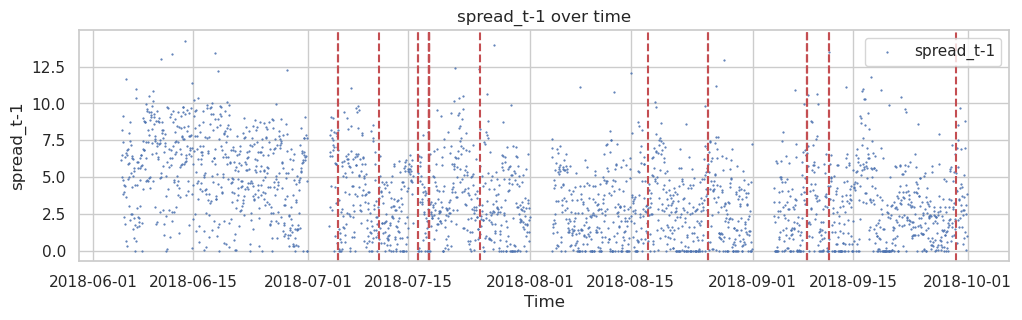

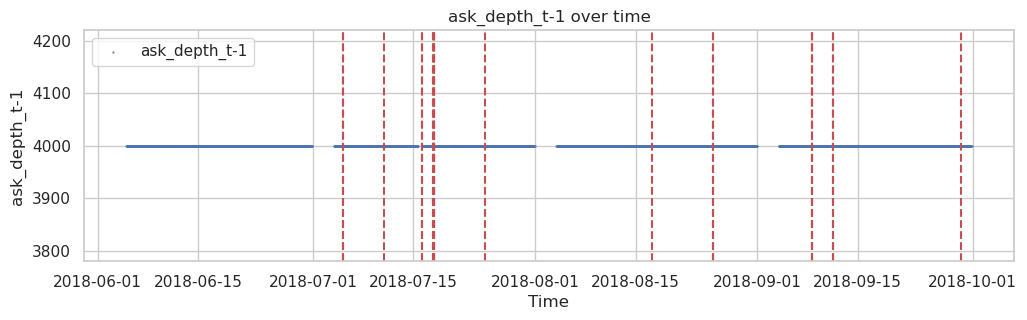

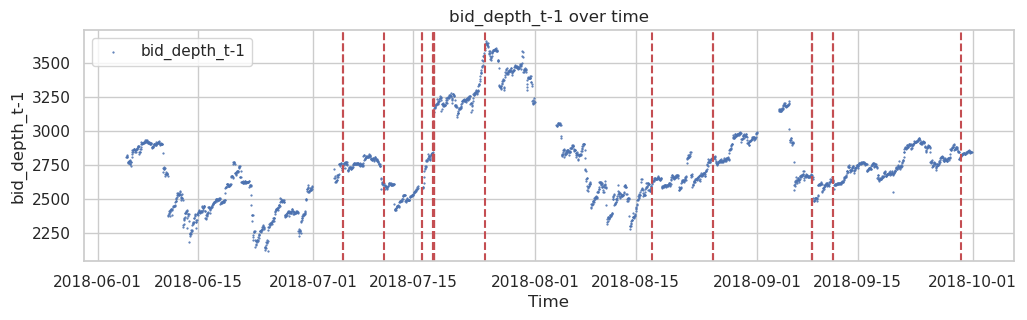

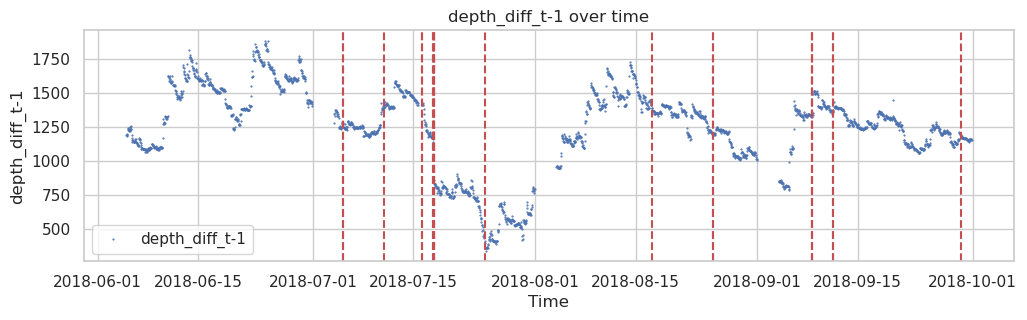

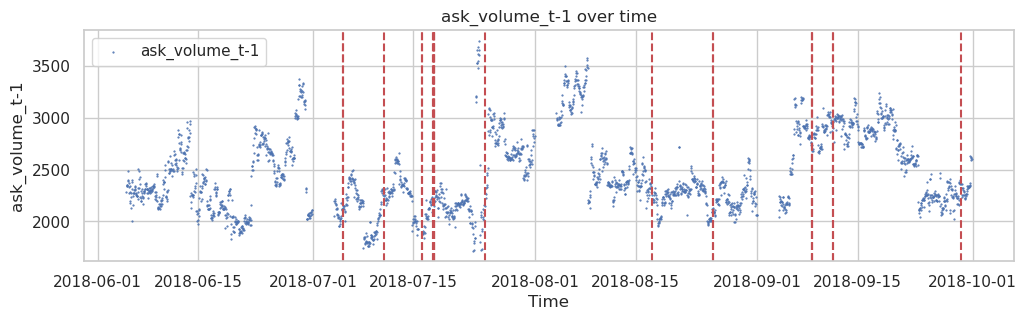

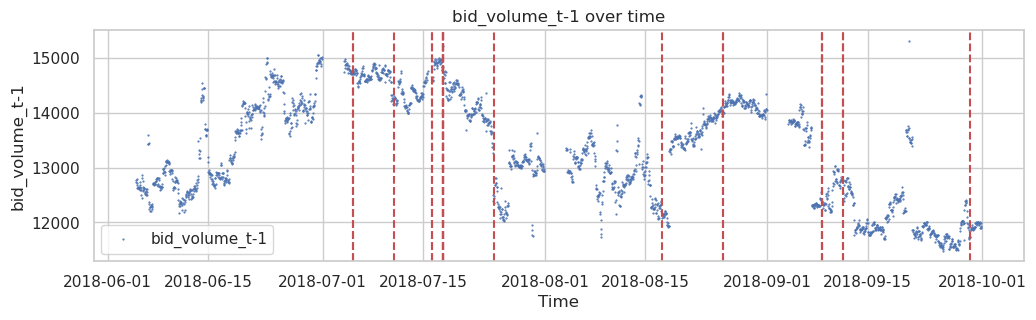

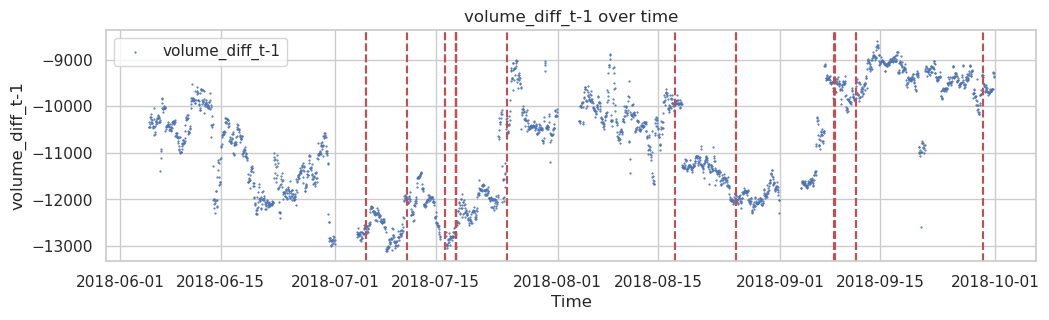

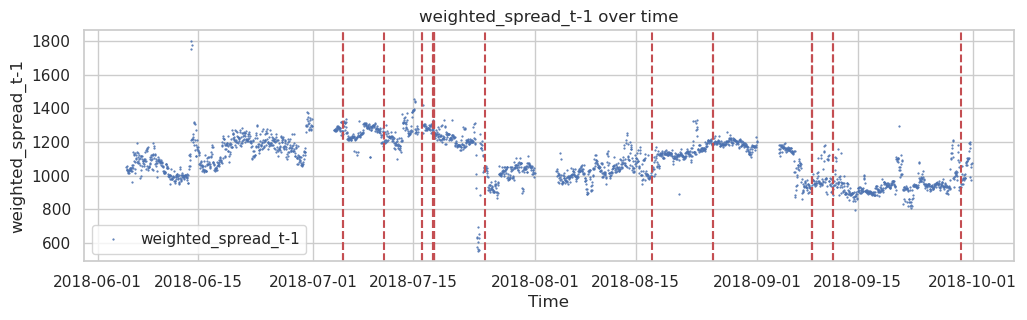

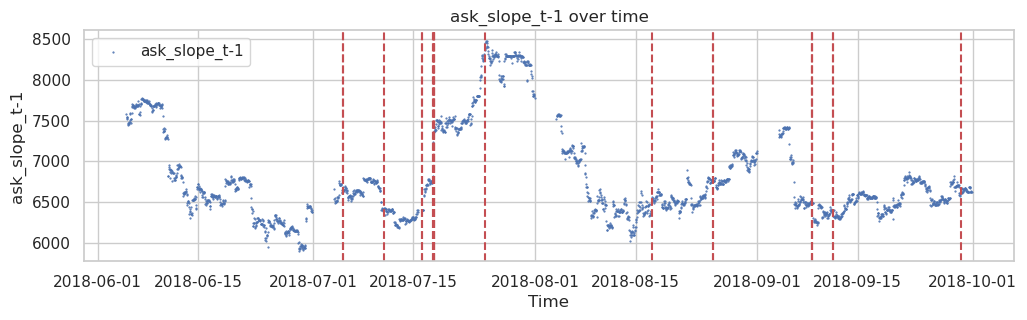

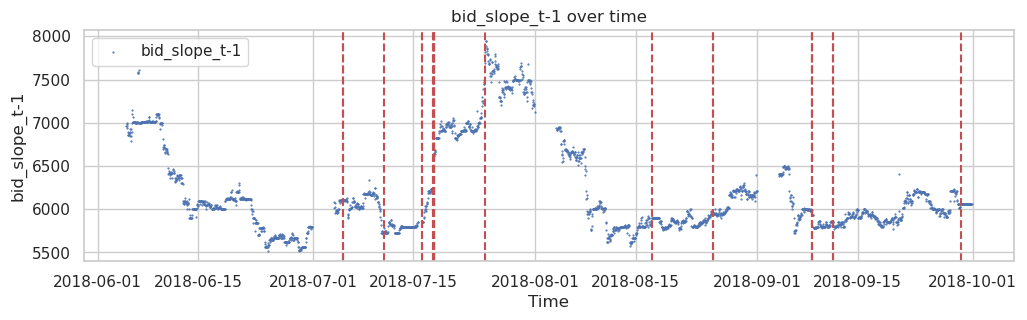

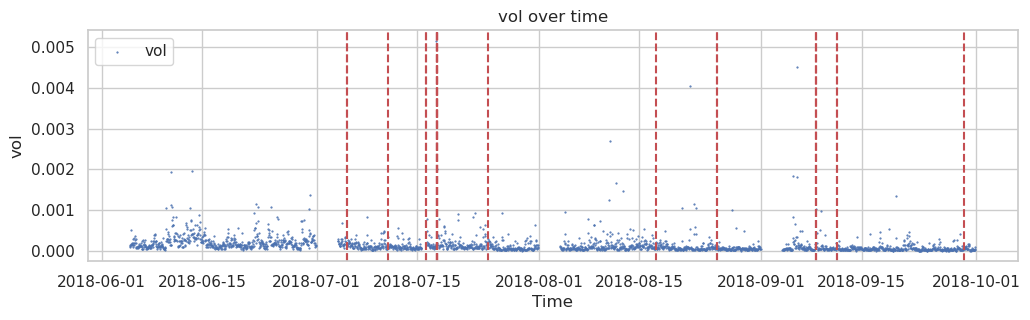

In [133]:
# plot vis_data


def plot_vis_data(df, feature, problematic_timestamps=None):
    plt.figure(figsize=(12, 3))
    plt.scatter(df["datetime"], df[feature], label=feature, alpha=1, s=0.3)
    plt.title(f"{feature} over time")
    plt.xlabel("Time")
    plt.ylabel(feature)
    plt.legend()
    if problematic_timestamps is not None:
        for timestamp in problematic_timestamps:
            plt.axvline(
                x=timestamp, color="r", linestyle="--", label="Problematic Timestamp"
            )
    plt.show()


for feature in vis_data.columns:
    if feature != "datetime":
        plot_vis_data(vis_data, feature, problematic_timestamps)

In [ ]:
# plot vis_features and features together
def plot_vis_features_and_features(df1, df2, feature, problematic_timestamps=None):
    plt.figure(figsize=(12, 3))
    plt.scatter(
        df1["datetime"], df1[feature + "_t-1"], label=feature + " (Vi)", alpha=1, s=0.3
    )
    plt.scatter(df2["time"], df2[feature], label=feature + " (Miro)", alpha=0.1, s=0.3)
    plt.title(f"{feature}")
    plt.xlabel("Time")
    plt.ylabel(feature)
    plt.legend()
    if problematic_timestamps is not None:
        for timestamp in problematic_timestamps:
            plt.axvline(
                x=timestamp, color="r", linestyle="--", label="Problematic Timestamp"
            )
    plt.show()

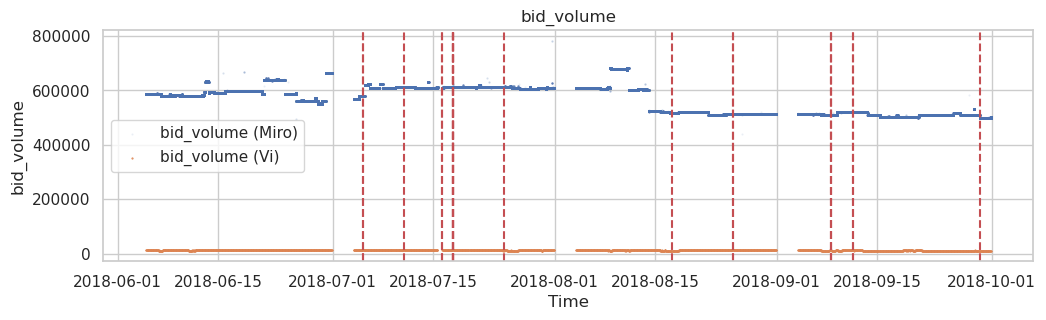

/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


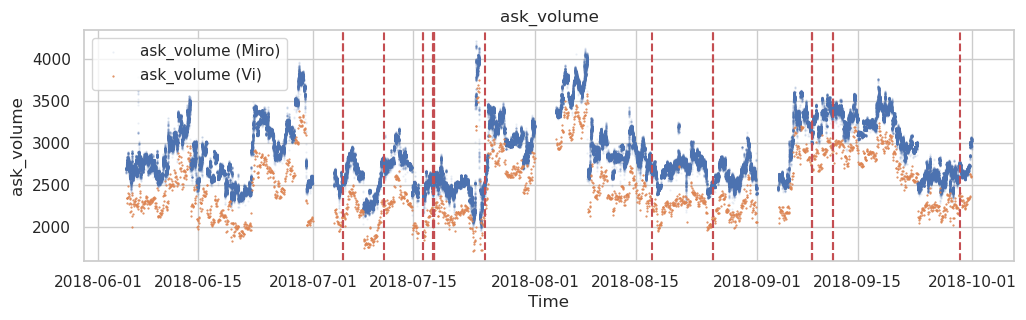

Error plotting max_bid: "max_bid_t-1" not found
Error plotting min_ask: "min_ask_t-1" not found


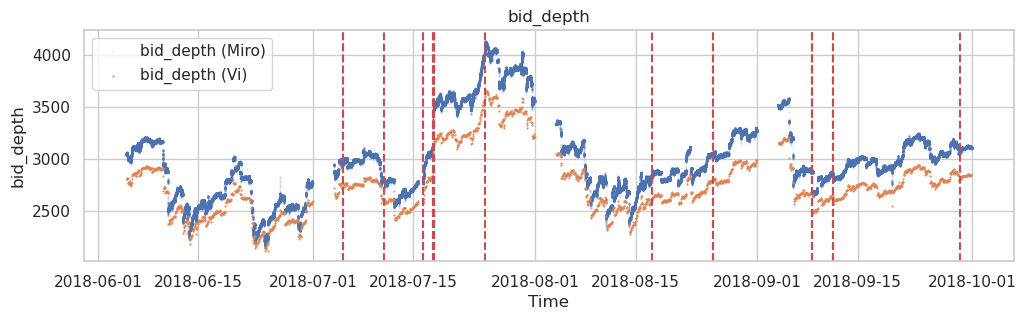

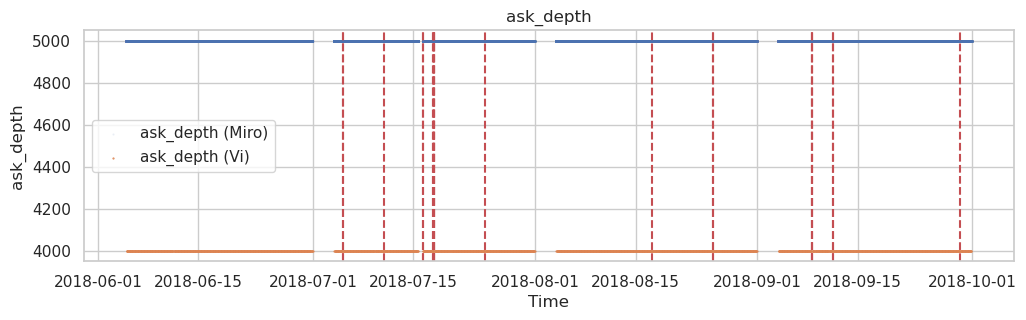

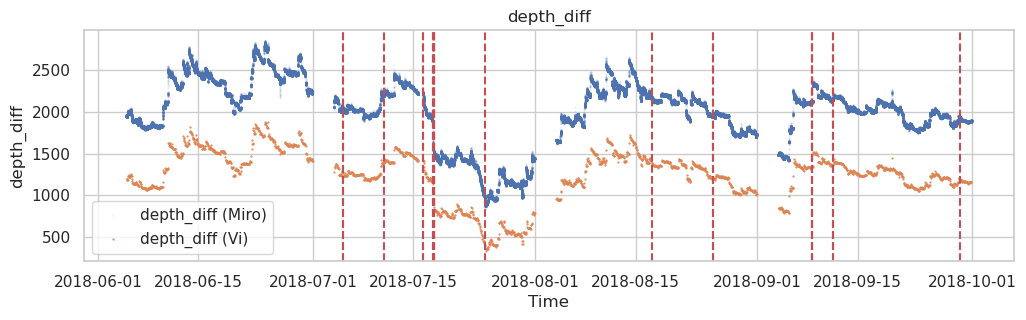

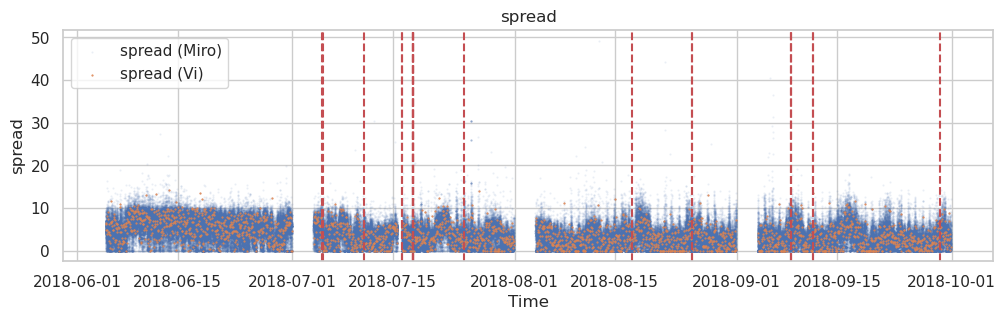

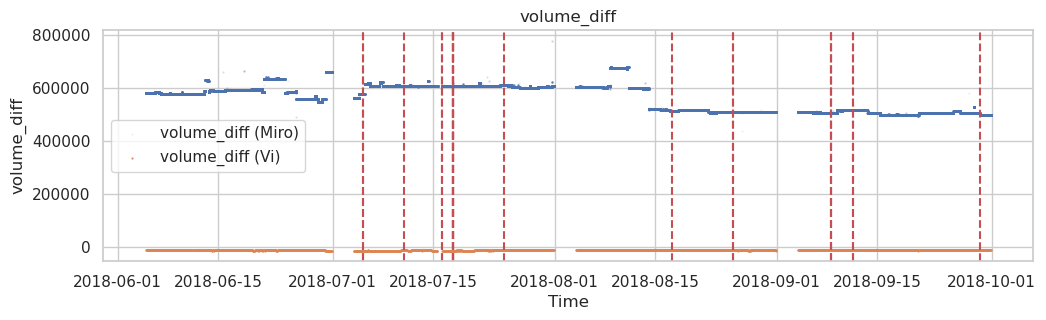

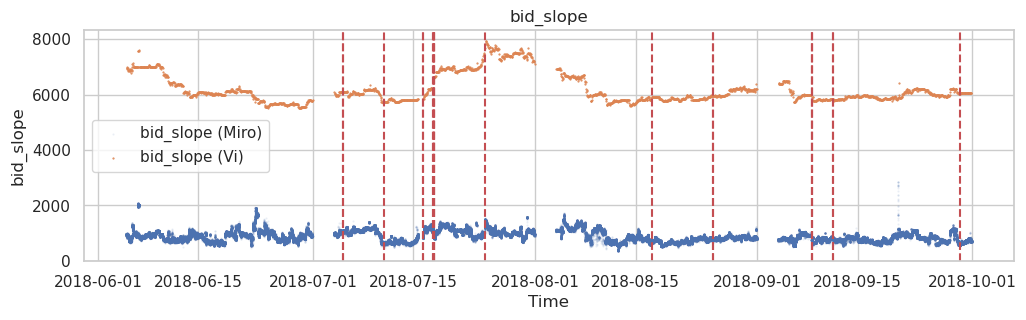

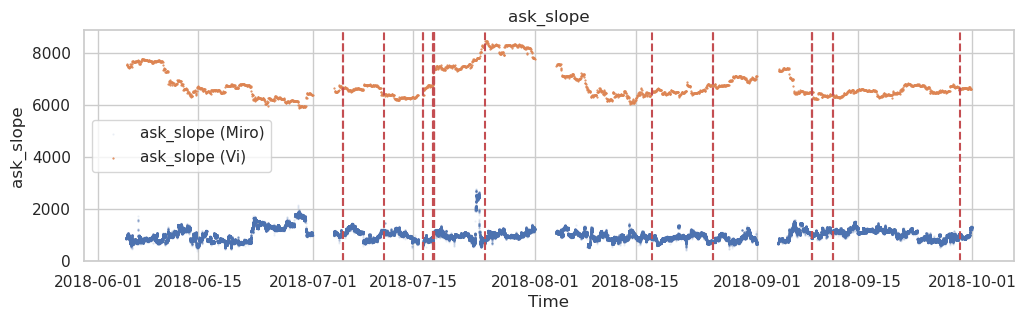

Error plotting weighted_bid: "weighted_bid_t-1" not found
Error plotting weighted_ask: "weighted_ask_t-1" not found


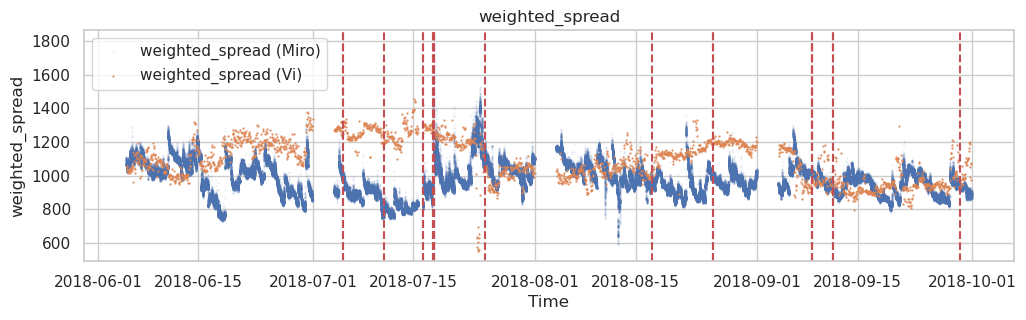

In [150]:
for feature in features.columns:
    if feature not in ["time"]:
        try:
            plot_vis_features_and_features(
                vis_data, features, feature, problematic_timestamps
            )
        except Exception as e:
            print(f"Error plotting {feature}: {e}")
            plt.close()

## Conclusions
- The outliers are not present in `data_df.csv` preprocessed by Viecheslav's code.
- Some features, like `weighted_spread`, `ask_slope`, `bid_slope` differ significantly in the methods of calculation (Miroslav's vs Viecheslav's). **TODO: check why is this the case.**

# PCA

In [8]:
feature_names = [
    "bid_volume",
    "ask_volume",
    "bid_depth",
    "ask_depth",
    "depth_diff",
    "spread",
    "volume_diff",
    "bid_slope",
    "ask_slope",
    # "weighted_bid",
    # "weighted_ask",
    "weighted_spread",
]

In [44]:
first_test_time = datetime.strptime("2018-07-01 00:00:00", "%Y-%m-%d %H:%M:%S")

In [45]:
# select features with prefix in feature_names

ob_features = vis_data.select(
    ["datetime"]
    + [f"{feature}_t-{i}" for feature in feature_names for i in range(1, 120)]
).filter(pl.col("datetime") < first_test_time)
ob_features

datetime,bid_volume_t-1,bid_volume_t-2,bid_volume_t-3,bid_volume_t-4,bid_volume_t-5,bid_volume_t-6,bid_volume_t-7,bid_volume_t-8,bid_volume_t-9,bid_volume_t-10,bid_volume_t-11,bid_volume_t-12,bid_volume_t-13,bid_volume_t-14,bid_volume_t-15,bid_volume_t-16,bid_volume_t-17,bid_volume_t-18,bid_volume_t-19,bid_volume_t-20,bid_volume_t-21,bid_volume_t-22,bid_volume_t-23,bid_volume_t-24,bid_volume_t-25,bid_volume_t-26,bid_volume_t-27,bid_volume_t-28,bid_volume_t-29,bid_volume_t-30,bid_volume_t-31,bid_volume_t-32,bid_volume_t-33,bid_volume_t-34,bid_volume_t-35,bid_volume_t-36,…,weighted_spread_t-83,weighted_spread_t-84,weighted_spread_t-85,weighted_spread_t-86,weighted_spread_t-87,weighted_spread_t-88,weighted_spread_t-89,weighted_spread_t-90,weighted_spread_t-91,weighted_spread_t-92,weighted_spread_t-93,weighted_spread_t-94,weighted_spread_t-95,weighted_spread_t-96,weighted_spread_t-97,weighted_spread_t-98,weighted_spread_t-99,weighted_spread_t-100,weighted_spread_t-101,weighted_spread_t-102,weighted_spread_t-103,weighted_spread_t-104,weighted_spread_t-105,weighted_spread_t-106,weighted_spread_t-107,weighted_spread_t-108,weighted_spread_t-109,weighted_spread_t-110,weighted_spread_t-111,weighted_spread_t-112,weighted_spread_t-113,weighted_spread_t-114,weighted_spread_t-115,weighted_spread_t-116,weighted_spread_t-117,weighted_spread_t-118,weighted_spread_t-119
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2018-06-04 23:00:00,12731.737072,12726.89278,12726.56146,12682.978896,12693.220325,12683.120976,12684.236255,12684.236184,12689.796627,12683.728902,12683.625744,12695.959284,12686.173596,12724.116767,12734.797367,12716.837525,12733.938296,12719.455895,12737.189415,12723.893512,12731.783532,12725.70278,12726.740565,12743.084609,12750.520199,12738.417595,12740.878058,12748.60156,12748.784152,12760.672069,12759.777541,12758.045721,12756.167335,12753.800566,12767.170336,12777.566117,…,1047.005269,1044.871429,1057.826536,1059.80738,1055.21349,1056.766862,1039.628432,1045.297616,1058.868431,1058.02805,1060.79946,1051.23505,1048.675398,1055.068116,1051.406531,1056.485104,1058.60645,1050.280736,1044.512593,1053.977541,1050.660655,1059.523912,1039.72849,1043.712118,1050.088413,1045.416674,1054.421408,1052.455523,1045.792897,1043.011224,1053.656605,1053.777802,1025.002432,1038.237774,1039.347393,1040.06992,1038.694529
2018-06-05 00:00:00,12783.096196,12779.53409,12778.562943,12779.894649,12780.225024,12781.2444,12781.63857,12779.673852,12779.567295,12752.972818,12729.014046,12755.304251,12754.086351,12643.476444,12682.237993,12722.11835,12708.740209,12707.546787,12710.206705,12720.895424,12723.555517,12719.855573,12716.653019,12725.792458,12719.748961,12722.43017,12731.682043,12729.36771,12730.504811,12737.48205,12737.341762,12739.643935,12732.982164,12732.176899,12718.818499,12730.955997,…,1032.719791,1027.648329,1029.228149,1036.931025,1033.237402,1033.687044,1032.467732,1035.994647,1030.117846,1023.20567,1026.820596,1037.153535,1029.315984,1029.425815,1029.130501,1040.742731,1031.436427,1041.928002,1040.769917,1036.27183,1030.392851,1024.095106,1044.18426,1025.124515,1021.825354,1016.822884,1018.839268,1034.426952,1037.227811,1031.075199,1029.904502,1039.863555,1032.4024,1032.533487,1042.644788,1038.317067,1042.515684
2018-06-05 01:00:00,12693.048433,12638.617613,12602.707947,12626.158586,12623.210974,12631.325672,12636.892859,12640.768082,12635.226853,12642.257182,12628.81928,12636.900518,12631.898399,12625.071043,12638.420528,12683.554671,12684.117765,12689.765878,12682.16891,12686.101206,12686.299034,12699.917864,12691.614111,12685.441764,12686.594325,12690.983535,12691.826351,12685.828546,12692.062818,12684.862517,12691.051202,12691.286253,12691.702029,12690.939663,12692.156001,12

In [ ]:
# PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
ob_features_scaled = scaler.fit_transform(ob_features.drop("datetime"))
# Perform PCA
pca = PCA(n_components=5)
ob_features_pca = pca.fit_transform(ob_features_scaled)
# Create a DataFrame with the PCA results
pca_df = pd.DataFrame(data=ob_features_pca, columns=["PC1", "PC2", "PC3", "PC4", "PC5"])
pca_df["datetime"] = ob_features["datetime"].to_numpy()
pca_df["datetime"] = pd.to_datetime(pca_df["datetime"])
pca_df = pca_df.sort_values("datetime")

In [47]:
pca_df.set_index("datetime", inplace=True)

<Axes: xlabel='datetime'>

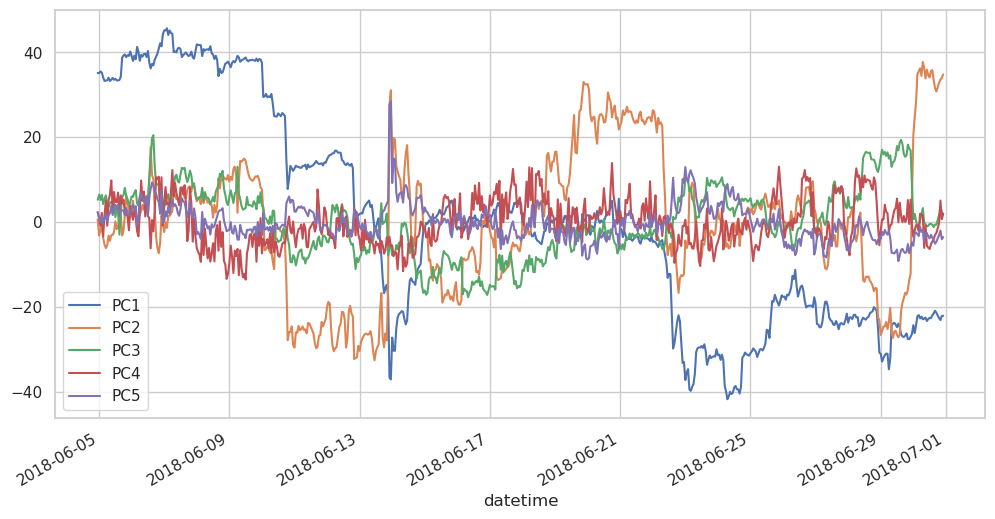

In [48]:
pca_df.plot(figsize=(12, 6))

In [43]:
# explained variance

explained_variance = pca.explained_variance_ratio_.cumsum()
explained_variance

array([0.54683901, 0.78796911, 0.84772339, 0.8745155 , 0.89118161])